In [4]:
import argparse
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ts.model.DataModel import Data
from ts.model.BayesModel import BaseLineModel
from ts.model.KalmanFilterModel import KalmanFilterChangePointModel
from ts.utils import gaussian

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--dummy', nargs='?', default='None')
parser.add_argument('--last-n-days', nargs='?', default='30', type=int)
parser.add_argument('--num-samples', nargs='*', default=1000, type=int)
parser.add_argument('--num-burnin', nargs='*', default=5000, type=int)
parser.add_argument("-c", "--config", dest='config_file', default='config.ini', type=str)
args = parser.parse_args(args=['--dummy'])

config = configparser.ConfigParser()
config.read(args.config_file)
args.s3_bucket = config.get('default', 's3_bucket')
args.s3_prefix = config.get('default', 's3_prefix')

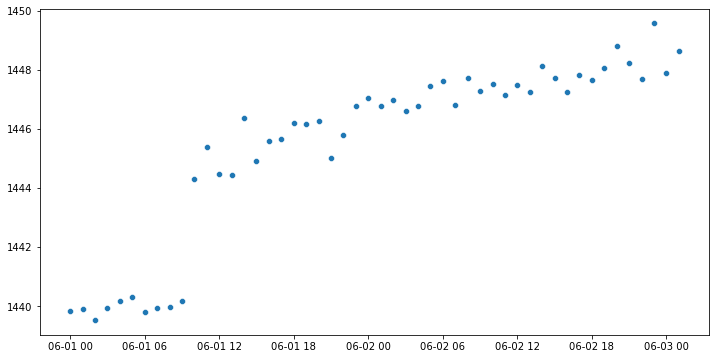

In [6]:
zs, ts, _ = BaseLineModel.sample_data(N=50, sp_loc=0.2, mu_1=1440, mu_2=1445, beta_1=0.03, beta_2=0.1, sigma_1=0.3, sigma_2=0.6)

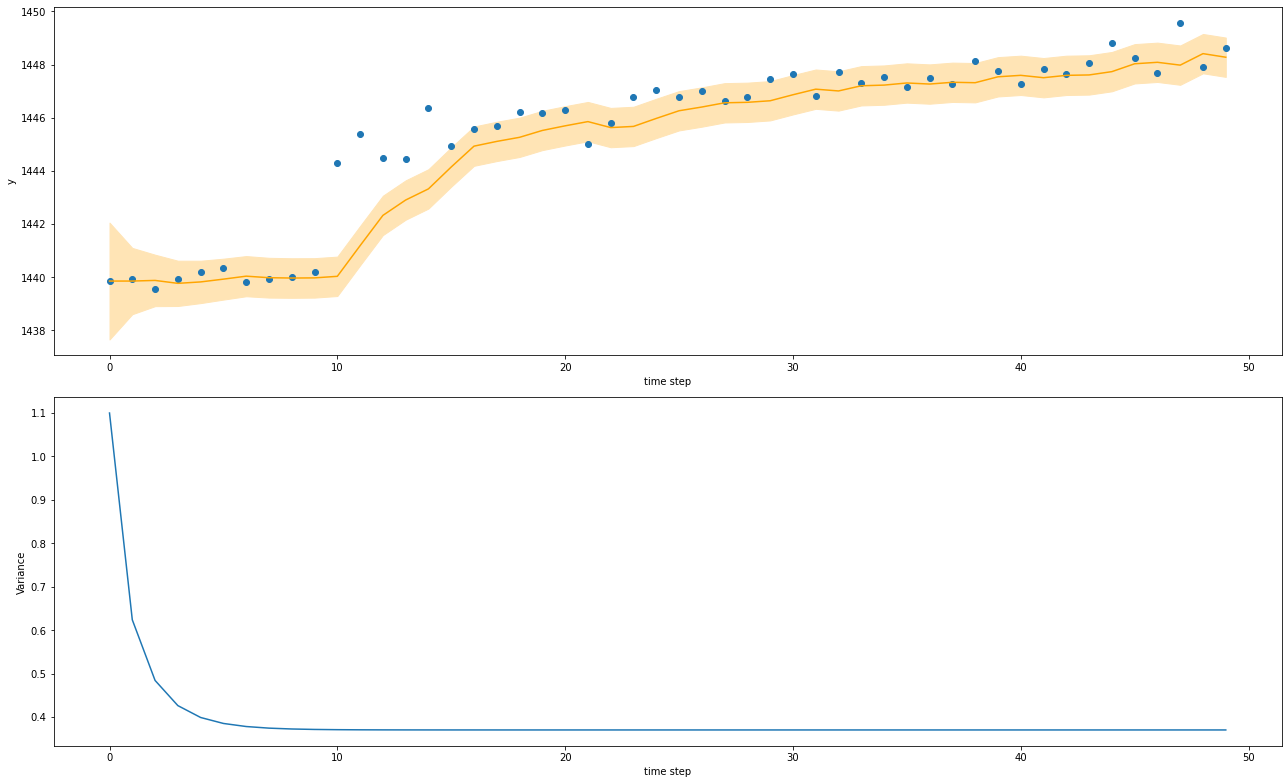

In [13]:
smoothing_param = 0.1
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)

In [14]:
data = Data(args.s3_bucket, args.s3_prefix, args.last_n_days)
data.get_raw_generator()
data.preprocessing()

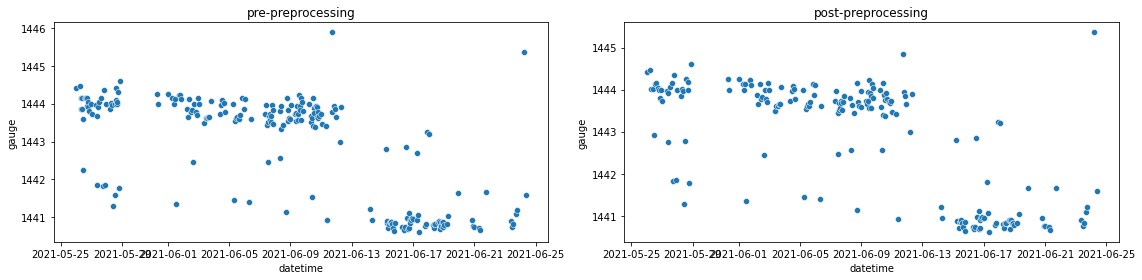

In [15]:
suspect = (9.65, 'Down')
target = 'gauge'
df = data.sub_df(*suspect, target)

sp_model = BaseLineModel.from_df(df=df, target=target, num_samples=args.num_samples, num_burnin=args.num_burnin)

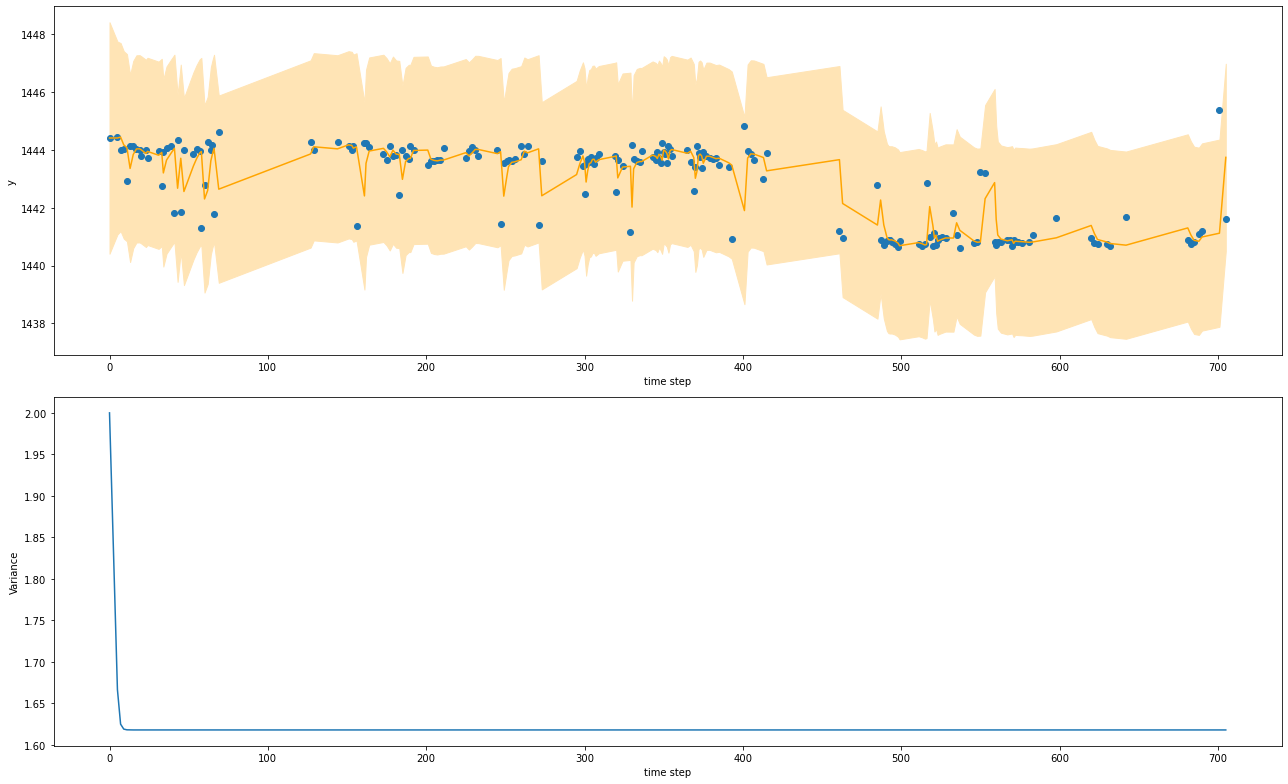

In [16]:
zs = sp_model.y
ts = sp_model.t
smoothing_param = 1
movement = gaussian(0, smoothing_param)
kf_model = KalmanFilterChangePointModel(changepoint_tolerance=5, residual_tolerance=0.5)
kf_model.fit(zs, movement, sensor_var=1)
kf_model.plot_all(ts, zs)